## Assignment for week 10

### Model implementation using pymc3

Generate data into a dataframe called data using numpy and pandas. Your data must be different from what was used in the examples already. Choose different parameters. The intention here is that you will test how changing parameters changes the results. Play around with trying out several different values.

In [1]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import packages
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as ss
import toyplot

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Anika\Miniconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
# fix a random seed
np.random.seed(123)

# generate data for 199 years with higher rates before 1920
data = pd.DataFrame({
    "year": np.arange(1200, 2018),
    "seedlings": np.concatenate([
        np.random.poisson(5.0, 400),
        np.random.poisson(1, 418),
    ])
})

In [7]:
data.head()

,seedlings,year
0,7,1200
1,5,1201
2,4,1202
3,8,1203
4,4,1204


In [15]:
seeds = data.iloc[:,0] #row,col

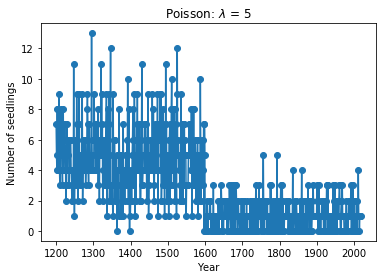

In [22]:
# plot
import matplotlib.pyplot as plt
rate = 5
n = np.arange(1200, 2018)
plt.plot(n,seeds, '-o')
plt.title('Poisson: $\lambda$ = %i' % rate)
plt.xlabel('Year')
plt.ylabel('Number of seedlings')
plt.show()

In [23]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.seedlings, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="# Seedlings",
);

1250 1500 1750 2000 year 0 5 10 15 # Seedlings

Implement a model that is appropriate for the data you have simulated. This can be a simple regression model like in notebook 10.4, or a more complex one like in notebook 10.6. Choose something that is interesting to you.

In [24]:
with pm.Model() as seedling_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1800)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    disasters = pm.Poisson('seedlings', rate, observed=data.seedlings)

Fit your model, plot the trace, and print the summary.

In [28]:
with seedling_model:
    trace = pm.sample(100)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
pm.traceplot(trace[100:])
plt.show()

NameError: name 'plt' is not defined

In [30]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1617.095000,21.485716,2.148054,1598.000000,1655.000000,1.0,2.379010
early_rate,4.725983,0.210850,0.020416,4.367386,5.081832,1.0,1.921122
late_rate,1.042912,0.046885,0.003893,0.971674,1.140698,127.0,1.017390


Using markdown, describe how closely your model predicted your generative parameters. Are your parameters within the 95% HPD interval? Do you think you ran the MCMC sampler long enough? Do you think anything went wrong? If so, what did you try to troubleshoot the problem? Did you seek help or answers?

The model predicted the switchpoint at 1617.095 which is close to the true value (1600). The parameters are within the 95% HPD interval (rate1 = 5, rate2 = 1). 

I only ran the MCMC for 100 iterations because it was taking hours to run. This was probably not enough time to get an accurate value (since it was 17.095 years off of the true value) but it still found the general region in the data where the transition happened. Furthermore, since the transition was defined by a change in parameter values, the model would probably not be able to find the exact true value regardless of how many iterations it was run for. 

The only part that I noticed that went wrong was plotting the trace which says it's missing plt. I did try to troubleshoot the problem by looking at other people's code plotting traces. Plt is often used as the abbreviation for `matplotlib.pyplot` so I tried installing matplotlib. I was able to make a graph with this but not of the trace. I also posted to the gitter chat room and tried to implement the suggestion that Patrick game me using `%matplotlib inline`. 